In [1]:
# Third party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from matplotlib.colors import LinearSegmentedColormap
# twinLab import
import twinlab as tl
import seaborn as sns
tl.set_user("cyd@digilab.co.uk")
tl.set_api_key("tl_oA4GuDIS9j6MIXEu502IdA")


          ====== TwinLab Client Initialisation ======
          Version     : 2.21.0
          User        : cyd@digilab.co.uk
          Server      : https://twinlab.digilab.co.uk/v3
          Environment : /Users/cyd/Desktop/twinLab/.env



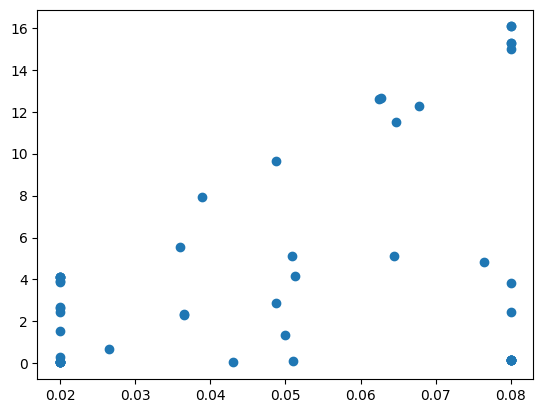

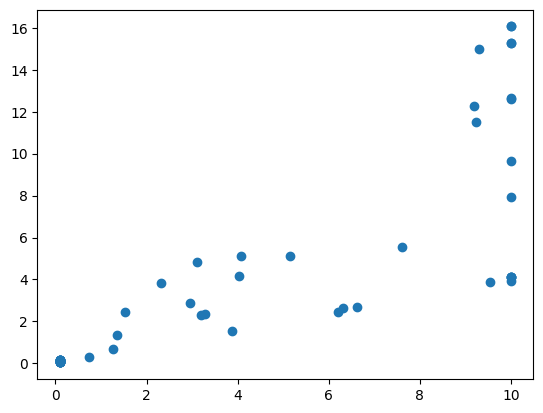

In [3]:
# read the training data from galaxy workflows

df = pd.read_csv("Data//tmap-active-loop_training_data.csv")

constant = 1E9
df_total = pd.DataFrame({
    "solubility": df["solubility"][:],
    "diffusivity":constant*(df["diffusivity"][:]),
    "thickness": df["thickness"][:],
    "output_flow":df["output_flow"][:]
})

# plot the relationship between indevidual inputs and outputs
plt.scatter(df_total["solubility"],df_total["output_flow"])
plt.show()

plt.scatter(df_total["diffusivity"],df_total["output_flow"])
plt.show()

In [4]:
# Define the name of the dataset
dataset_id = "UoM_dataset"

# Intialise a Dataset object
dataset = tl.Dataset(id=dataset_id)

# Upload the dataset
dataset.upload(df_total, verbose=True)

Dataframe is uploading.
Dataset successfully uploaded.


In [15]:
# Initialise emulator
emulator_id = "UoM_emulator"
emulator = tl.Emulator(id=emulator_id)

# Define the training parameters for your emulator
output_columns = ["output_flow"]
params = tl.TrainParams(
    train_test_ratio=0.6,
    estimator="gaussian_process_regression",

)

# Train the emulator using the train method
emulator.train(
    dataset=dataset,
    inputs=["diffusivity","solubility","thickness"],
    outputs=output_columns,
    params=params,
    verbose=True,
)

Emulator 'UoM_emulator' has begun training.
0:00:00: Job status: processing
0:00:01: Job status: processing
0:00:03: Job status: processing
0:00:05: Job status: processing
0:00:07: Job status: processing
0:00:10: Job status: processing
0:00:12: Job status: success
Training of emulator UoM_emulator is complete!


In [16]:
# validation step
# calculate mean standardized log loss
params = tl.ScoreParams(metric="MSLL", combined_score=True)
MSLLscore = emulator.score(params=params)

# calculate R squared
params = tl.ScoreParams(metric="R2", combined_score=True)
R2score = emulator.score(params=params)

print(MSLLscore,R2score)

# stopping criterion for active learning loop
if MSLLscore < -1.5 and R2score>0.95:
    print("model is good")

-4.6348295856064246 0.9999468009027838
model is good


{'dataset': ',solubility,diffusivity,thickness,output_flow\n30,0.062461,10.0,1.9,12.621227\n31,0.08,10.0,1.9,16.067202\n32,0.08,9.307338,1.9,14.981916\n33,0.076476,3.113832,1.934397,4.811185\n34,0.02,10.0,1.9,4.122752\n35,0.035903,7.618895,1.918128,5.561718\n36,0.08,0.1,2.0,0.159947\n37,0.08,10.0,2.0,15.283807\n38,0.036547,3.290198,2.0,2.369697\n39,0.02,0.1,1.9,0.042194\n40,0.02,6.628954,1.9515,2.674365\n41,0.036508,3.20278,2.0,2.304888\n42,0.02,3.886378,2.0,1.537633\n43,0.043029,0.1,2.0,0.086145\n44,0.049924,1.343295,2.0,1.328127\n45,0.08,2.309305,1.9,3.812111\n46,0.02,0.1,2.0,0.040087\n47,0.051298,4.037345,1.951085,4.157025\n48,0.062662,10.0,1.9,12.661048\n49,0.08,0.1,1.9,0.168344\n', 'dataset_url': None}
Job predict process ID: predict-gem-tidy-guarantee
0:00:00: Job status: processing
0:00:01: Job status: processing
0:00:03: Job status: processing
0:00:05: Job status: processing
0:00:07: Job status: processing
0:00:10: Job status: processing
0:00:12: Job status: success
Mean predic

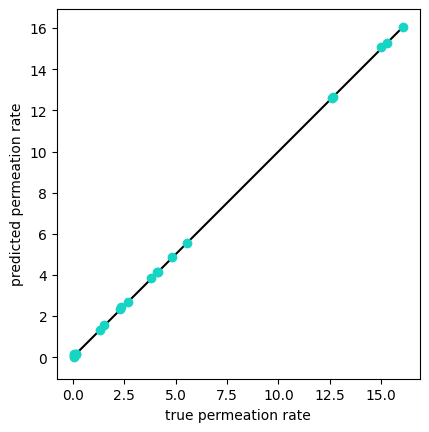

In [18]:
# create a validation plot, comparing predictions to true values for test data
test_data = emulator.view_test_data()
ytrue = test_data["output_flow"]
ypred,yprederr = emulator.predict(test_data)

fig,axs = plt.subplots(1,1)
plt.errorbar(ytrue,ypred["output_flow"],yerr=yprederr["output_flow"],linestyle="",marker="o",color="#16D5C2")
plt.plot([np.min(ytrue),np.max(ytrue)],[np.min(ytrue),np.max(ytrue)],color="black")
plt.xlabel("true permeation rate")
plt.ylabel("predicted permeation rate")
axs.set_aspect("equal")
plt.savefig("validation.png",dpi=300,transparent=True)
plt.show()

In [43]:

df_obs = pd.DataFrame({'output_flow': [8]})
df_std = pd.DataFrame({'output_flow': [0.01]})
calibparams = tl.CalibrateParams(start_location="optimized",return_summary=False,n_chains=2,iterations=20000)
calib_results = emulator.calibrate(df_obs, df_std,params=calibparams,verbose=True)

Job calibrate process ID: calibrate-flame-chipped-astronomy
0:00:00: Job status: processing
0:00:01: Job status: processing
0:00:03: Job status: processing
0:00:05: Job status: processing
0:00:07: Job status: processing
0:00:10: Job status: processing
0:00:13: Job status: processing
0:00:16: Job status: processing
0:00:19: Job status: processing
0:00:23: Job status: processing
0:00:27: Job status: processing
0:00:31: Job status: processing
0:00:36: Job status: processing
0:00:41: Job status: processing
0:00:47: Job status: processing
0:00:54: Job status: processing
0:01:01: Job status: processing
0:01:09: Job status: success
Calibration:
       chain   draw  diffusivity  solubility  thickness
0          0      0     7.231077    0.045311   1.488641
1          0      1     7.231077    0.045311   1.488641
2          0      2     7.231077    0.045311   1.488641
3          0      3     7.231077    0.045311   1.488641
4          0      4     7.231077    0.045311   1.488641
...      ...    ..

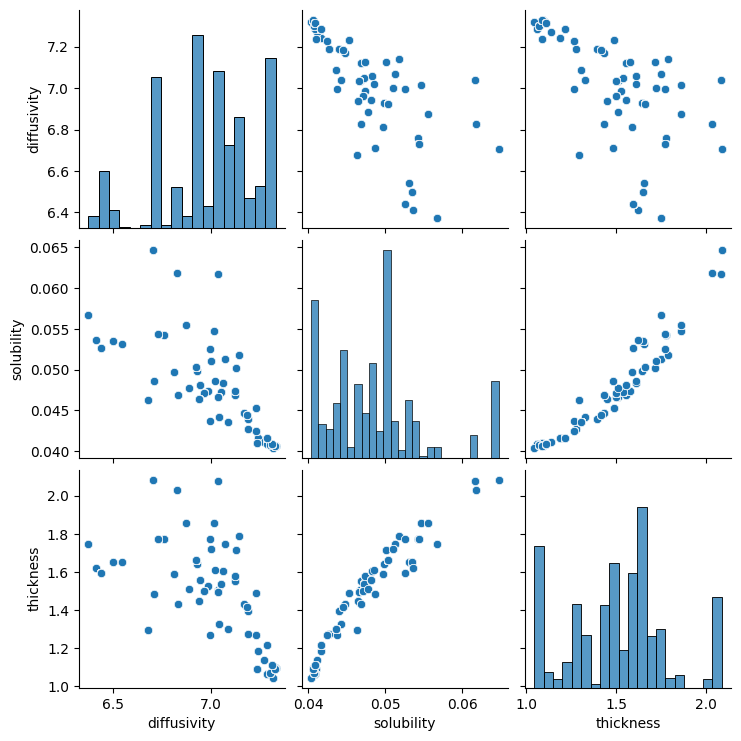

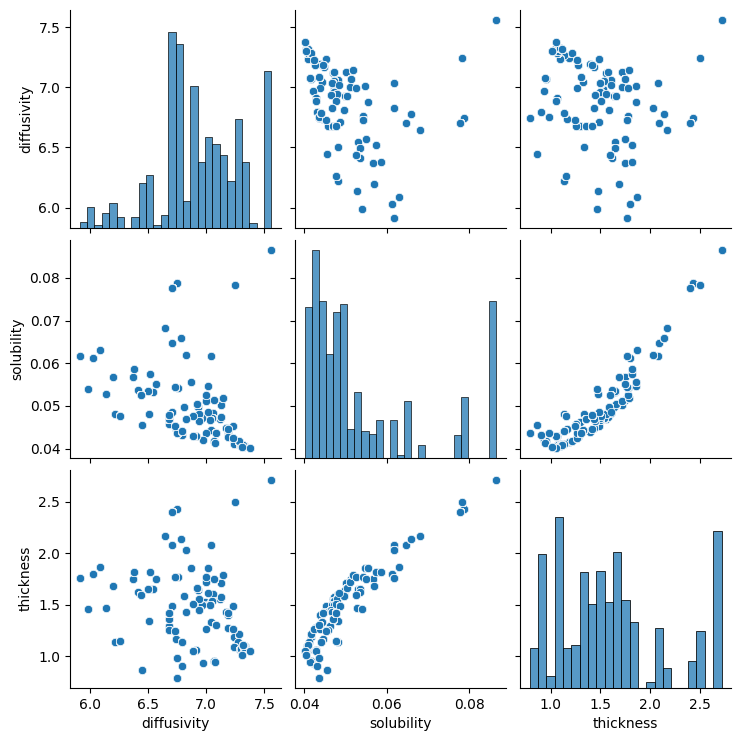

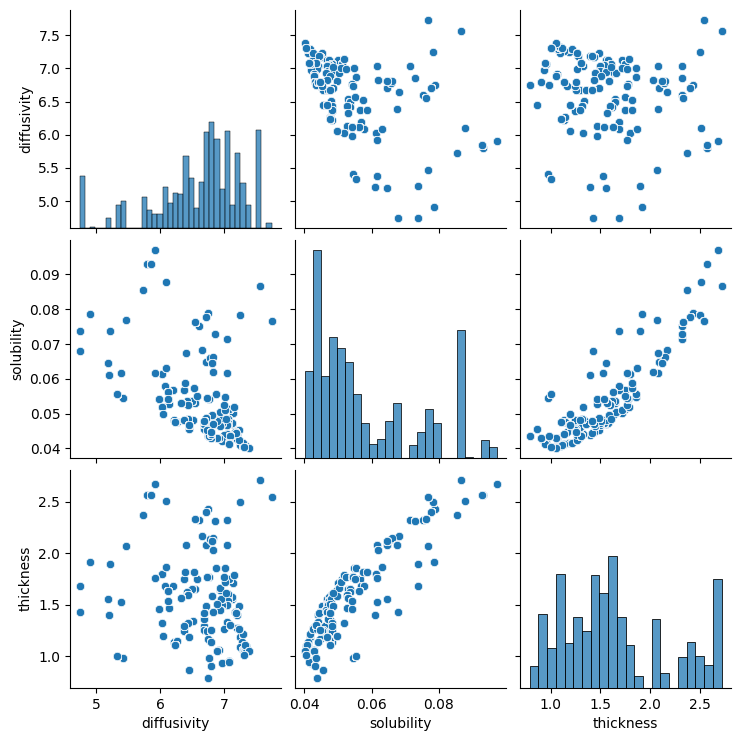

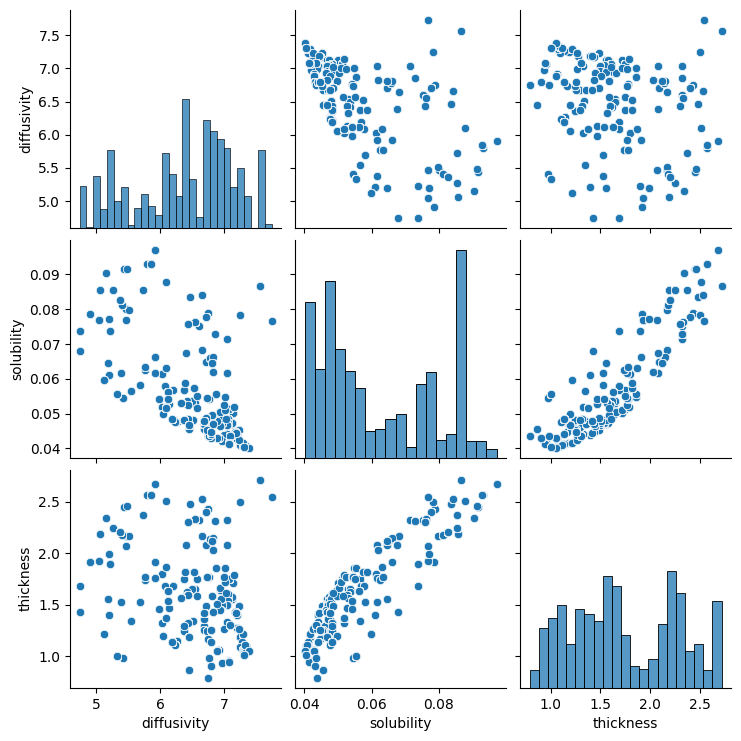

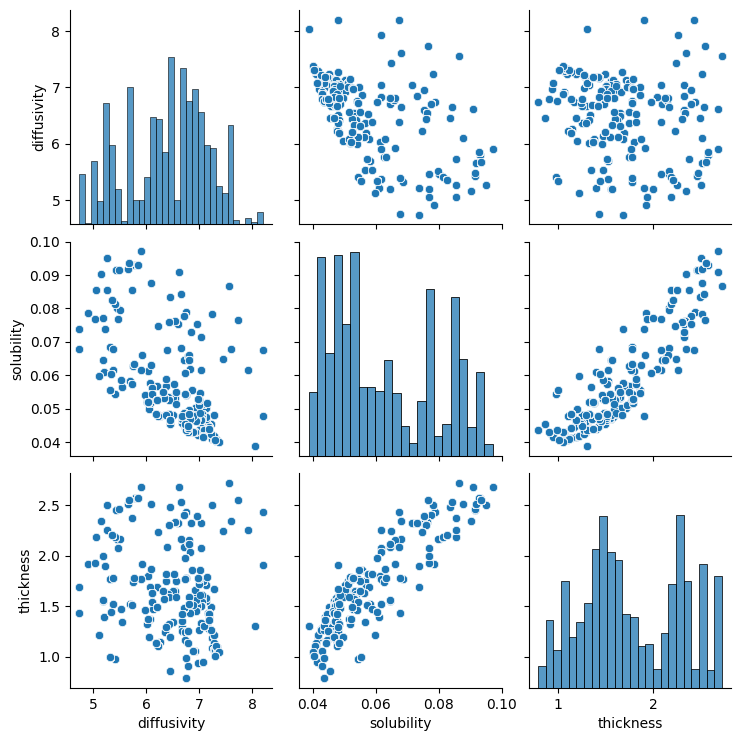

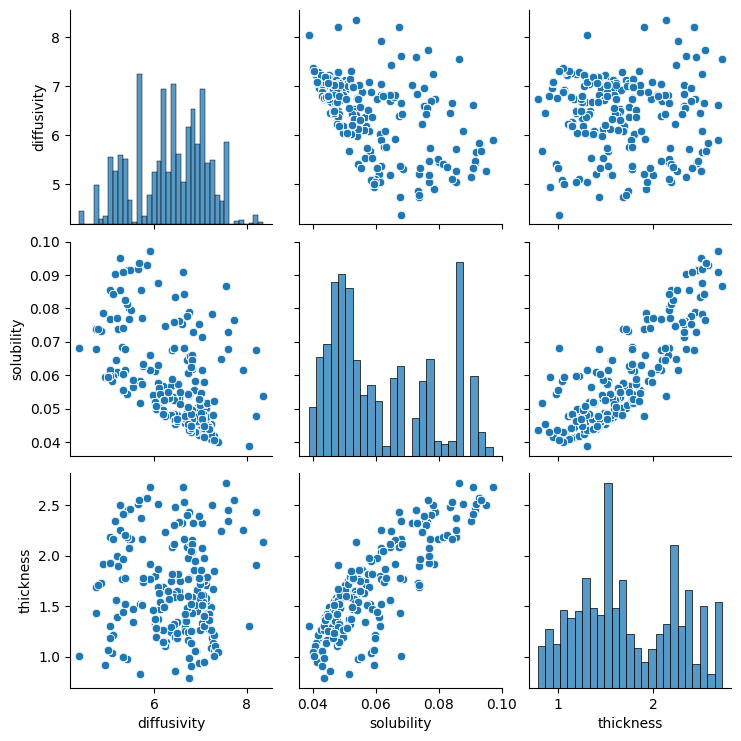

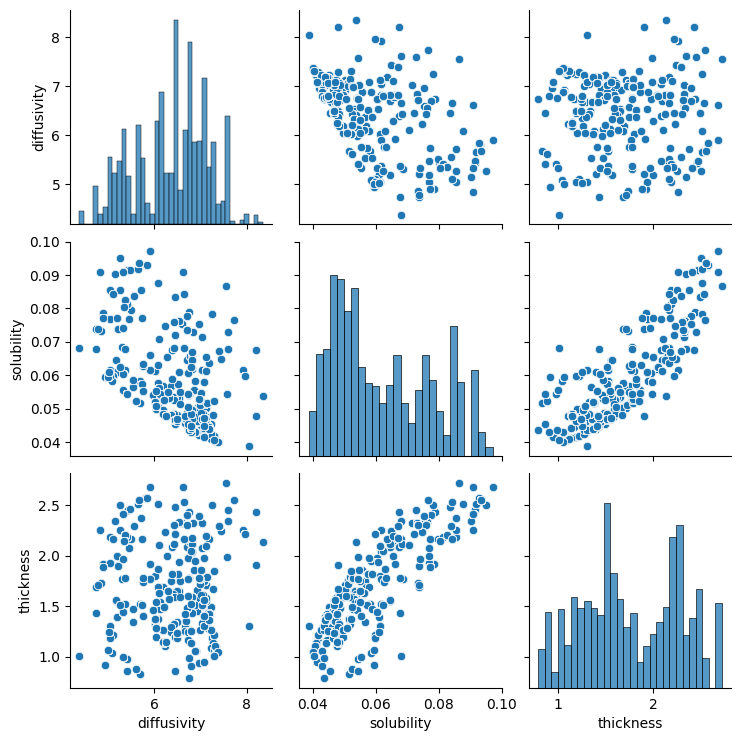

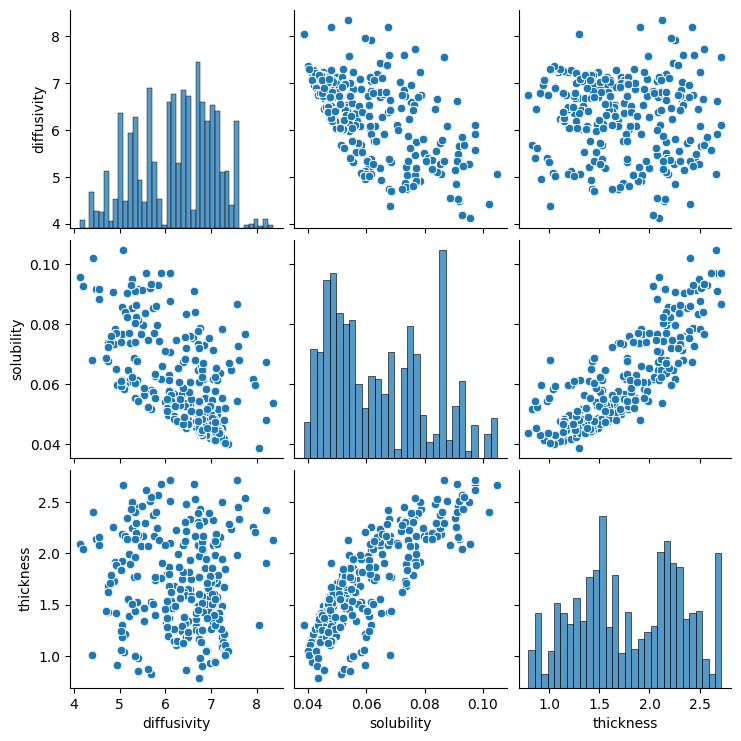

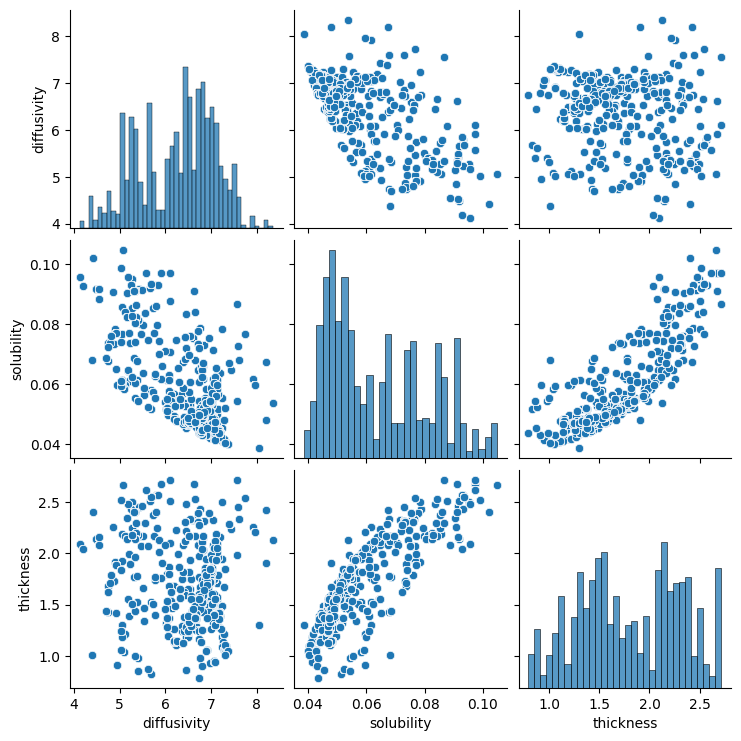

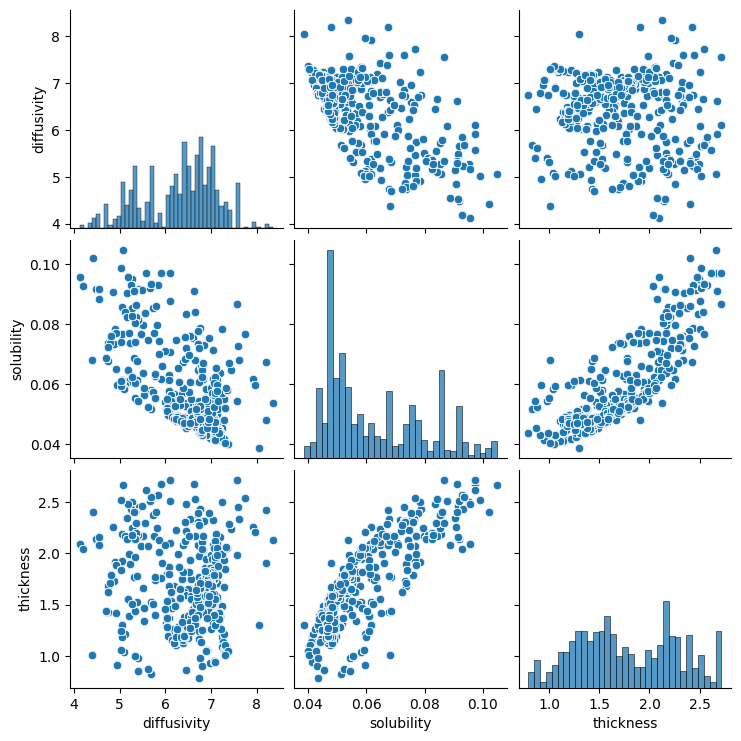

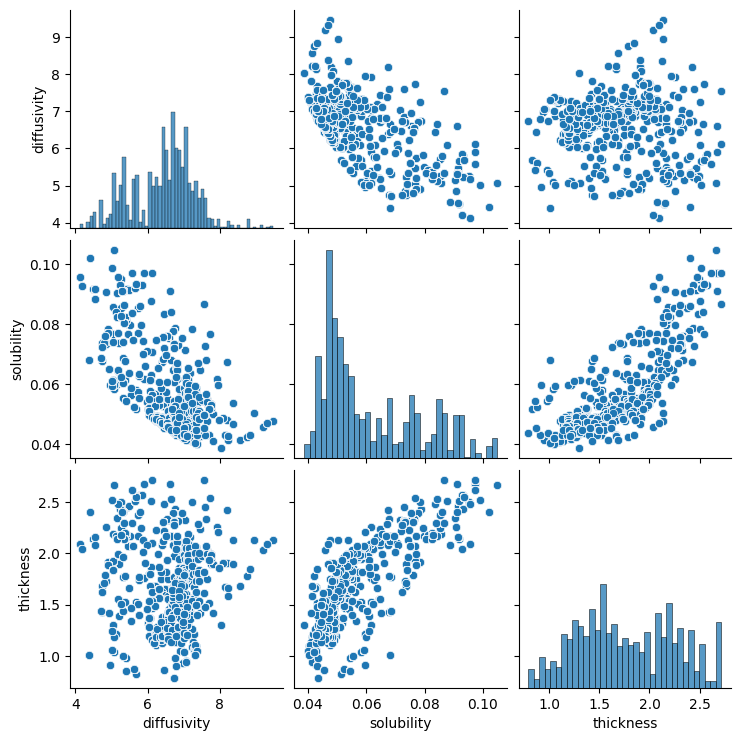

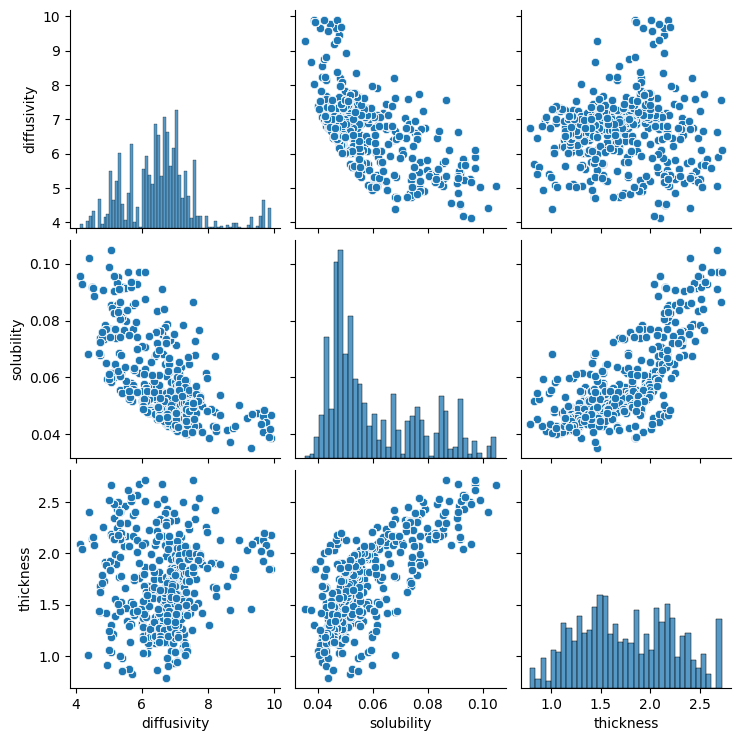

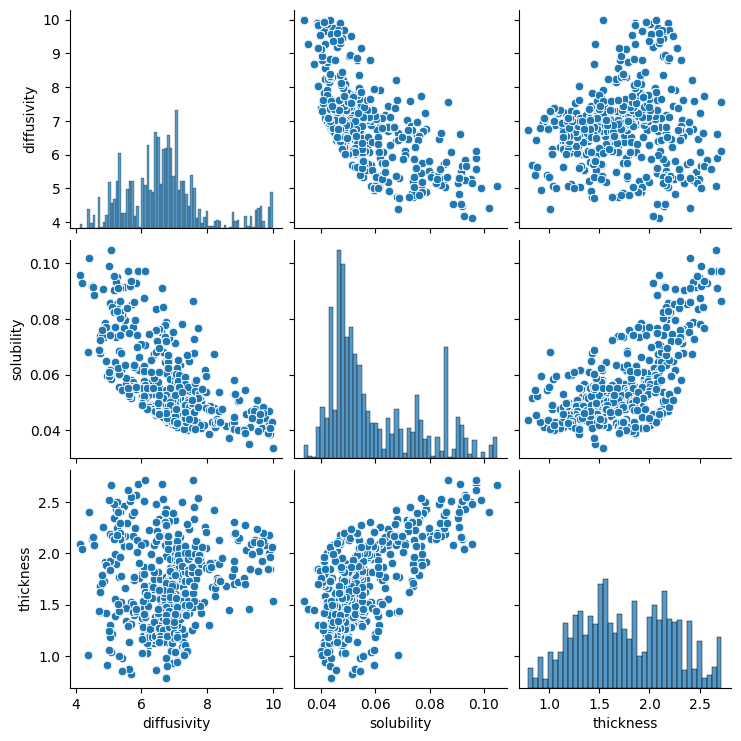

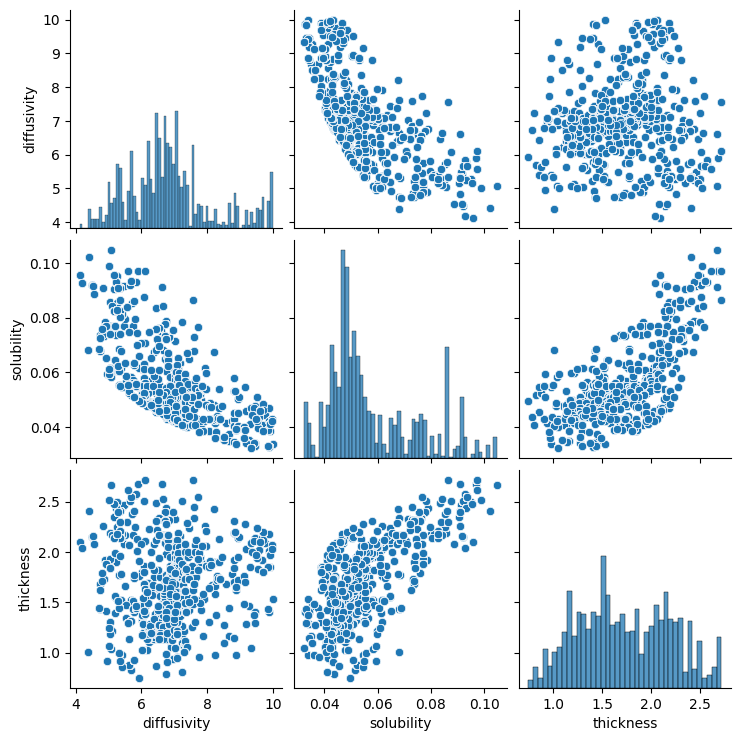

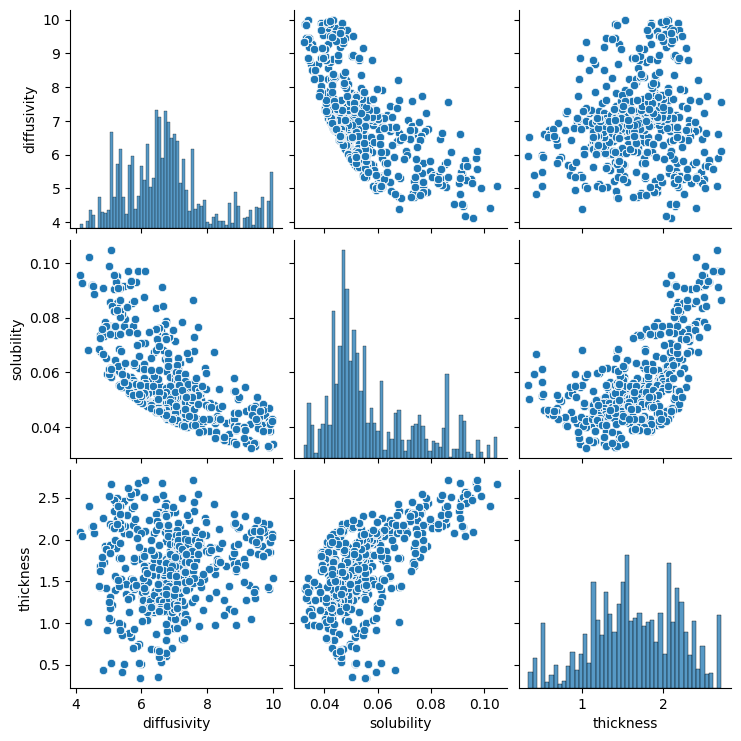

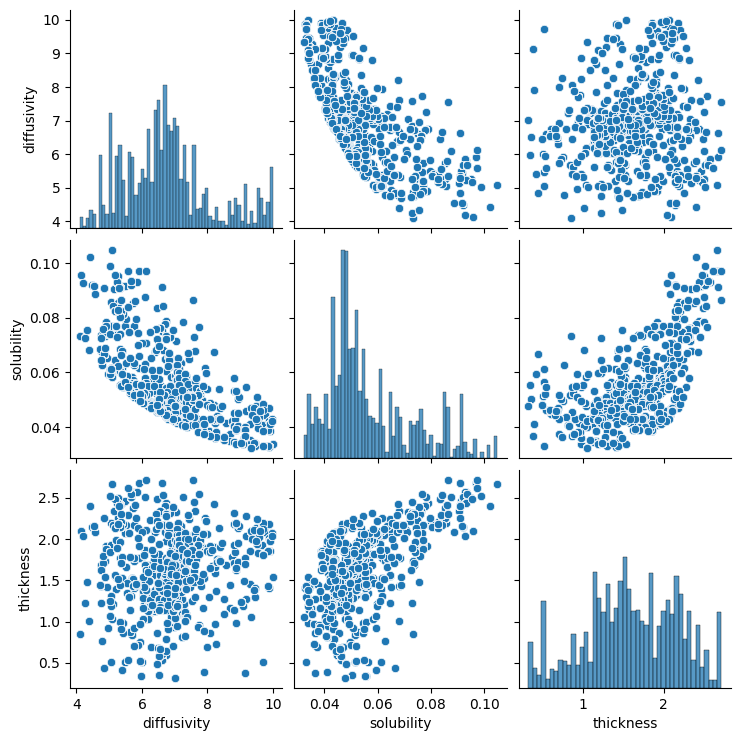

In [44]:
for j in range(2000,len(calib_results),2000):
    plotdata = calib_results.iloc[:j, [2,3,4]]

    pairplot = sns.pairplot(plotdata)
    plt.savefig("Figures_pairplots//"+str(j)+".png",dpi=300,bbox_inches="tight")
    plt.show()
# plt.hist2d(10**calib_results["logdiffusivity"],calib_results["solubility"])

In [ ]:
import glob
import os
from PIL import Image
def create_gif(input_folder, output_path, duration=200, loop=0):
    """
    Create a GIF from a folder of images.

    Args:
        input_folder (str): Path to the folder containing images.
        output_path (str): Path to save the output GIF.
        duration (int): Duration between frames in milliseconds.
        loop (int): Number of times the GIF should loop (0 = infinite).
    """
    # Collect all images (common formats)
    image_files = sorted(
        glob.glob(os.path.join(input_folder, "*.png")) +
        glob.glob(os.path.join(input_folder, "*.jpg")) +
        glob.glob(os.path.join(input_folder, "*.jpeg"))
    )

    if not image_files:
        raise ValueError("No images found in the specified folder.")

    # Open images
    images = [Image.open(img).convert("RGBA") for img in image_files]

    # Save as GIF
    images[0].save(
        output_path,
        save_all=True,
        append_images=images[1:],
        duration=duration,
        loop=loop
    )

    print(f"GIF saved at {output_path}")

create_gif("Figures_pairplots","calibration.gif",duration=800)

GIF saved at calibration.gif
